In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as cores

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR

/home/notebook-lab/.conda/envs/granger/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def seasonal_decompose_df(df):
    return df.apply(lambda s: seasonal_decompose(s, freq=200)).apply(lambda x: x.resid).transpose()

In [3]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15, 1))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    print('Passed:' , dftest[0] < dftest[4]['1%'])

In [4]:
data_path = '/home/notebook-lab/Downloads/dbv3/'
columns = ['tout'] + ['xmeas'+ str(i+1) for i in range(22)]
data_parser = lambda dates: pd.to_datetime(dates, unit='h')
sim_df = pd.read_csv(data_path + 'data/simout_14.csv',
                     index_col='tout',
                     usecols=range(23),
                     parse_dates=['tout'],
                     date_parser=data_parser)
# sim_df.head()

In [5]:
stat_sim_df = seasonal_decompose_df(sim_df)

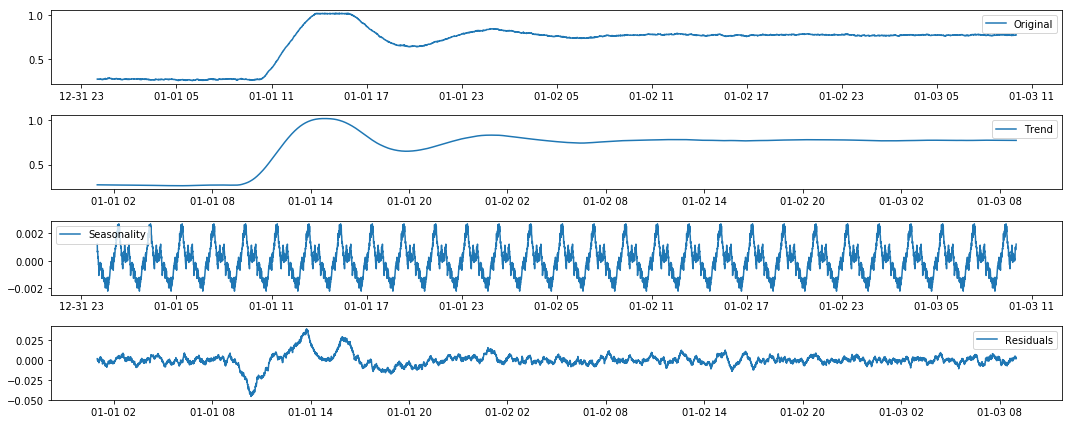

In [6]:
# Exemplo de decomposição
decomposition = seasonal_decompose(sim_df['xmeas1'], freq=200)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(sim_df['xmeas1'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

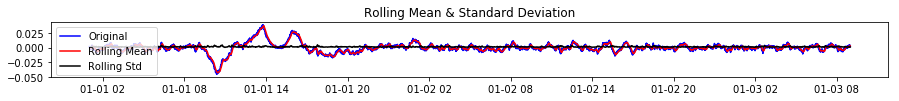

Results of Dickey-Fuller Test:
Test Statistic                   -5.165990
p-value                           0.000010
#Lags Used                       14.000000
Number of Observations Used    5586.000000
Critical Value (1%)              -3.431521
Critical Value (5%)              -2.862058
Critical Value (10%)             -2.567045
dtype: float64
Passed: True


In [7]:
test_stationarity(residual.dropna())

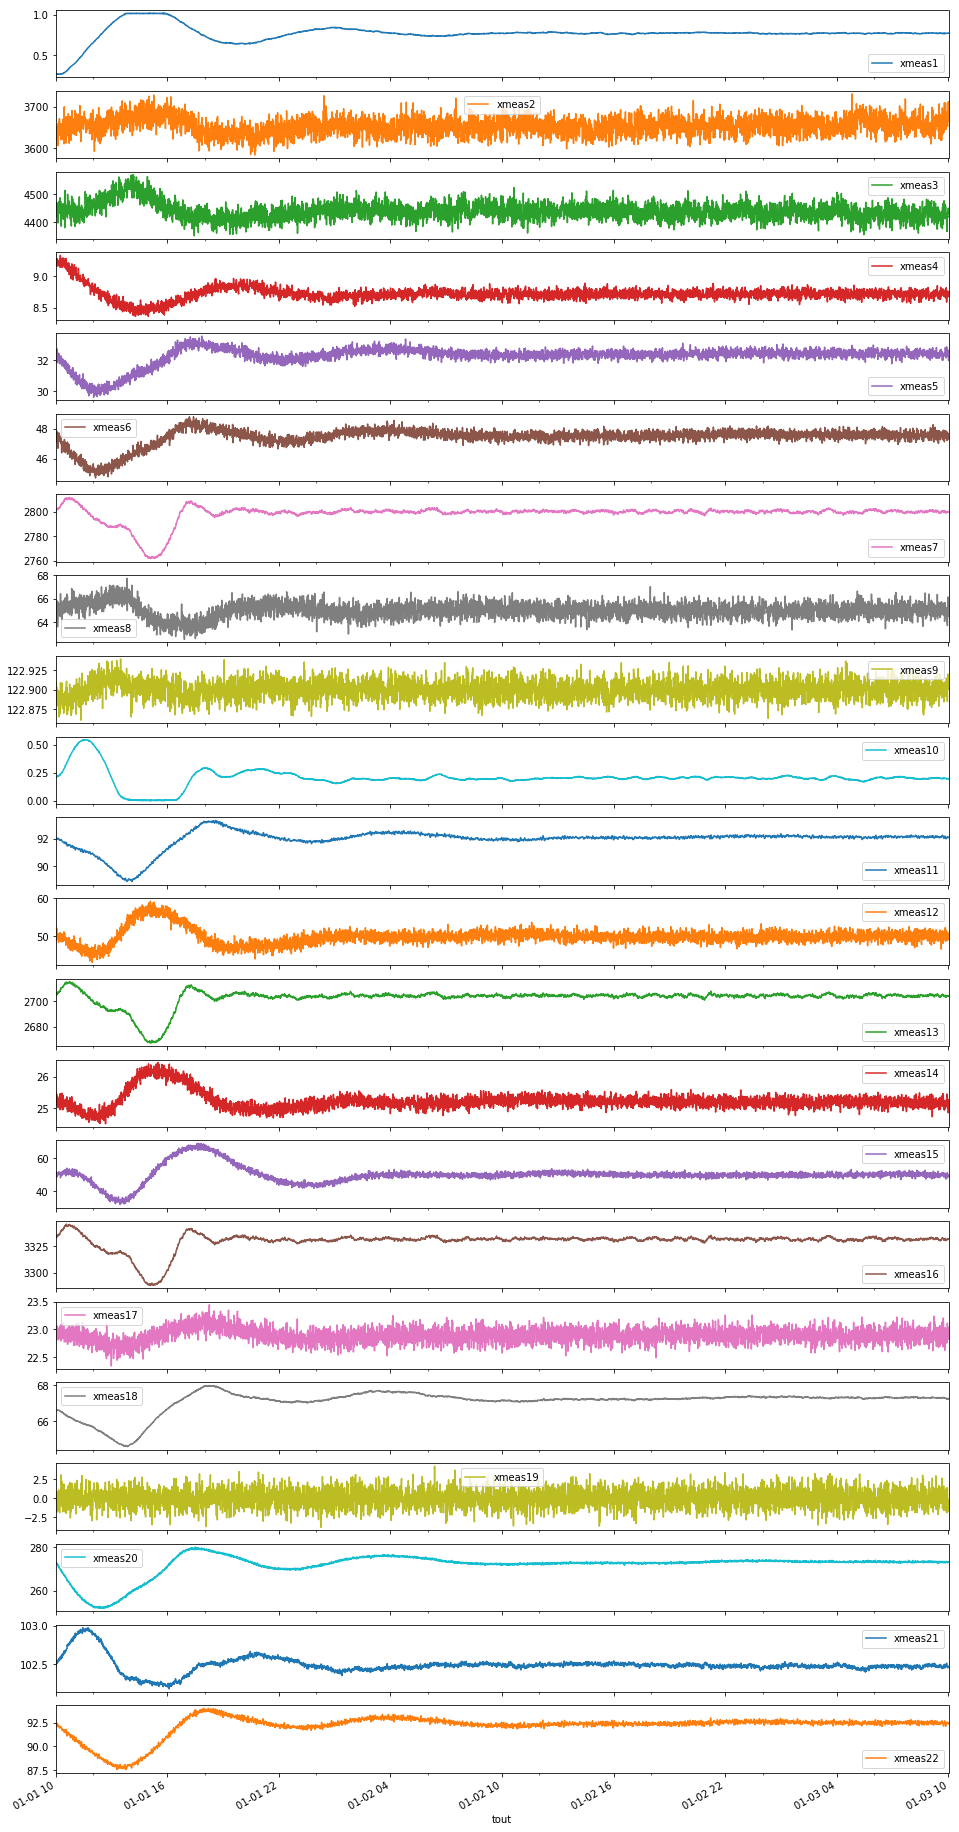

In [8]:
sim_df.iloc[1000:].plot(subplots=True, figsize=(16, 36))
plt.show()

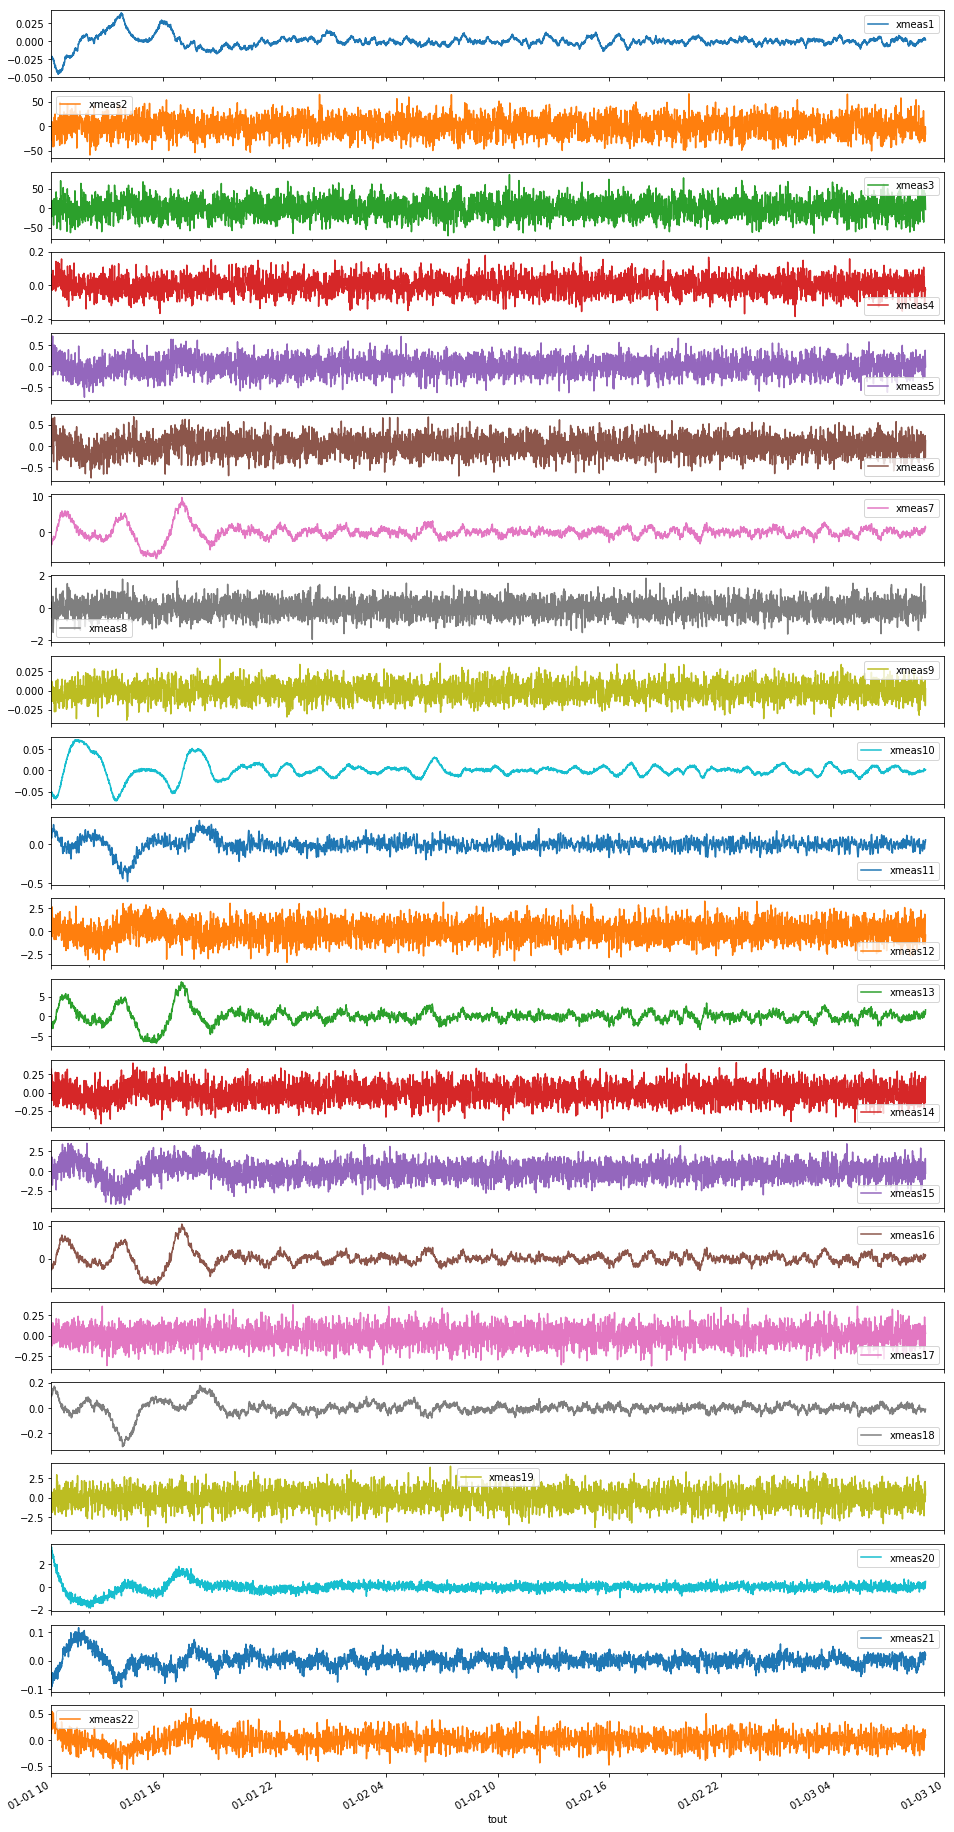

In [10]:
stat_sim_df.iloc[1000:].plot(subplots=True, figsize=(16, 36))
plt.show()

In [56]:
model = VAR(stat_sim_df[['xmeas13', 'xmeas16']].dropna())

model.select_order(maxlags=20)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0       -0.3742      -0.3718       0.6879      -0.3733
1        -3.660       -3.653      0.02573       -3.657
2        -3.672       -3.660      0.02544       -3.667
3        -3.688       -3.672      0.02501       -3.683
4        -3.697       -3.676      0.02479       -3.690
5        -3.725       -3.699      0.02412       -3.716
6        -3.738       -3.707      0.02380       -3.727
7        -3.748      -3.713*      0.02355       -3.736
8        -3.750       -3.710      0.02351      -3.736*
9        -3.751       -3.706      0.02349       -3.736
10       -3.751       -3.701      0.02350       -3.733
11       -3.752       -3.697      0.02348       -3.733
12       -3.751       -3.691      0.02351       -3.730
13       -3.751       -3.686      0.02351       -3.728
14       -3.750       -3.681      0.02352       -3.726
15       -

{'aic': 17, 'bic': 7, 'fpe': 17, 'hqic': 8}

In [28]:
results = model.fit(20)

In [34]:
results.test_causality('xmeas13', 'xmeas16', kind='f')

Granger causality f-test
   Test statistic   Critical Value          p-value            df
-----------------------------------------------------------------
        14.995305         1.570615            0.000  (20, 113080)
H_0: ['xmeas16'] do not Granger-cause xmeas13
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 1.5706147685165641,
 'df': (20, 113080),
 'pvalue': 1.0067857343065891e-51,
 'signif': 0.05,
 'statistic': 14.995305471890683}

In [54]:
a = sm.tsa.stattools.grangercausalitytests(stat_sim_df[['xmeas13', 'xmeas16']].dropna(), maxlag=27, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=839.0706, p=0.0000  , df_denom=5597, df_num=1
ssr based chi2 test:   chi2=839.5204, p=0.0000  , df=1
likelihood ratio test: chi2=782.2498, p=0.0000  , df=1
parameter F test:         F=839.0706, p=0.0000  , df_denom=5597, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=318.1790, p=0.0000  , df_denom=5594, df_num=2
ssr based chi2 test:   chi2=636.9267, p=0.0000  , df=2
likelihood ratio test: chi2=603.2317, p=0.0000  , df=2
parameter F test:         F=318.1790, p=0.0000  , df_denom=5594, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=245.5806, p=0.0000  , df_denom=5591, df_num=3
ssr based chi2 test:   chi2=737.6642, p=0.0000  , df=3
likelihood ratio test: chi2=692.9499, p=0.0000  , df=3
parameter F test:         F=245.5806, p=0.0000  , df_denom=5591, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=198.9933, p=0.

ssr based F test:         F=26.2958 , p=0.0000  , df_denom=5516, df_num=28
ssr based chi2 test:   chi2=743.8908, p=0.0000  , df=28
likelihood ratio test: chi2=698.2613, p=0.0000  , df=28
parameter F test:         F=26.2958 , p=0.0000  , df_denom=5516, df_num=28

Granger Causality
number of lags (no zero) 29
ssr based F test:         F=25.2681 , p=0.0000  , df_denom=5513, df_num=29
ssr based chi2 test:   chi2=740.6160, p=0.0000  , df=29
likelihood ratio test: chi2=695.3639, p=0.0000  , df=29
parameter F test:         F=25.2681 , p=0.0000  , df_denom=5513, df_num=29

Granger Causality
number of lags (no zero) 30
ssr based F test:         F=24.4546 , p=0.0000  , df_denom=5510, df_num=30
ssr based chi2 test:   chi2=741.7585, p=0.0000  , df=30
likelihood ratio test: chi2=696.3648, p=0.0000  , df=30
parameter F test:         F=24.4546 , p=0.0000  , df_denom=5510, df_num=30

Granger Causality
number of lags (no zero) 31
ssr based F test:         F=23.6305 , p=0.0000  , df_denom=5507, df_num=3

In [ ]:
VAR()